In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit

from pysim import SimBoostRegressor, SimBoostClassifier

## Regression

```python
from pysim import SimBoostRegressor
clf = SimBoostRegressor(n_estimators, stein_method="first_order", spline="a_spline", learning_rate=0.1, reg_lambda=0.1, reg_gamma=0.1, knot_dist="uniform", degree=2, knot_num=20, ortho_shrink=1, loss_threshold=0.01, val_ratio=0.2, random_state=0)
```

In [3]:
random_state = 0
np.random.seed(random_state)
# data generation
beta1 = np.array([.2, 0.3, 0.5, 0, 0, 0, 0, 0, 0, 0])
beta2 = np.array([0, .2, 0.3, 0.5, 0, 0, 0, 0, 0, 0])
beta3 = np.array([0, 0, 0.2, 0.3, 0.5, 0, 0, 0, 0, 0])

beta = np.vstack([beta1, beta2, beta3])
model_list = [lambda x: 0.2 * np.exp(-4 * x), lambda x: 3 * x ** 2, lambda x: 2.5 * np.sin(1.5 * np.pi * x)]

x = truncnorm.rvs(a=-3, b=3, loc = 0, scale=1 / 3, size=(20000, 10), random_state=random_state)
noise = np.random.randn(20000).reshape(-1, 1)
y = np.reshape(0.2 * np.exp(-4 * np.dot(x, beta1)) + \
               3 * (np.dot(x, beta2)) ** 2 + 2.5 * np.sin(np.pi * 1.5 * np.dot(x, beta3)), [-1, 1]) + noise
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)

In [69]:
%%time 

clf = SimBoostRegressor(n_estimators=10, knot_num=20, knot_dist="uniform", spline="a_spline", learning_rate=0.1,
                        reg_lambda=[0.1, 0.2, 0.3, 0.4, 0.5],
                        reg_gamma=[0.2])
clf.fit(train_x, train_y, inner_update=False)

CPU times: user 1min 26s, sys: 3min 24s, total: 4min 51s
Wall time: 4.75 s


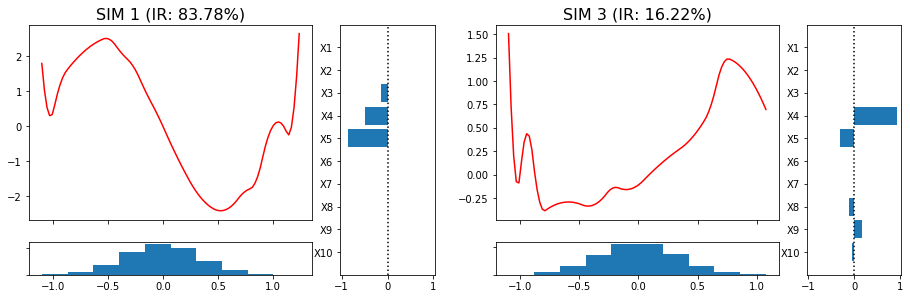

In [70]:
clf.visualize()

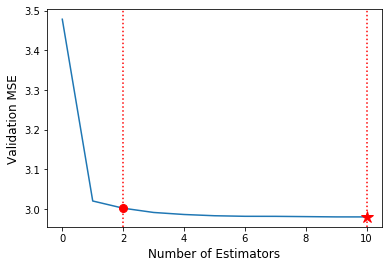

In [71]:
clf.validation_performance()

In [72]:
component_importance = {}
for indice, est in enumerate(clf.sim_estimators_):
    component_importance.update({"sim " + str(indice + 1): {"type": "sim", "indice": indice,
                         "importance": np.std(est.predict(train_x[clf.tr_idx, :]))}})

for indice, est in enumerate(clf.dummy_estimators_):
    feature_name = list(est.named_steps.keys())[0]
    component_importance.update({feature_name: {"type": "dummy_lr", "indice": indice,
                         "importance": np.std(est.predict(x[clf.tr_idx, :]))}})

clf.estimators_ = []
pred_val = clf.intercept_ * np.ones(len(clf.val_idx))
clf.val_mse_ = [mean_squared_error(y[clf.val_idx], pred_val)]
for key, item in sorted(component_importance.items(), key=lambda item: item[1]["importance"])[::-1]:

    if item["type"] == "sim":
        est = clf.sim_estimators_[item["indice"]]
        pred_val += est.predict(train_x[clf.val_idx])
    elif item["type"] == "dummy_lr":
        est = clf.dummy_estimators_[item["indice"]]
        pred_val += est.predict(train_x[clf.val_idx])

    clf.estimators_.append(est)
    clf.val_mse_.append(mean_squared_error(train_y[clf.val_idx], pred_val))
clf.val_mse_

[3.6627008352126973,
 1.0761263464307051,
 1.131017645049889,
 1.1285749472826896,
 1.1755241374406369,
 1.2103652634033668,
 1.2199068214780258,
 1.2251261298905516,
 1.2268563891802582,
 1.228916884361723,
 1.2337834915122052]

In [63]:
mean_squared_error(test_y, clf.predict(test_x))

1.6627627948579184

In [75]:
x = test_x
pred = clf.intercept_ * np.ones(x.shape[0])
for est in clf.best_estimators_:
    if "sim" in est.named_steps.keys():
        pred += est.predict(x)
    elif "dummy_lr" in est.named_steps.keys():
        pred += est.predict(x)
mean_squared_error(test_y, pred)

1.166562768349263

## LogitBoost

```python
from pysim import SimBoostClassifier
clf = SimBoostClassifier(n_estimators, stein_method="first_order", spline="a_spline", learning_rate=0.1, reg_lambda=0.1, reg_gamma=0.1, knot_dist="uniform", degree=2, knot_num=20, ortho_shrink=1, loss_threshold=0.01, val_ratio=0.2, random_state=0)
```

In [7]:
random_state = 0
np.random.seed(random_state)
# data generation
beta1 = np.array([.2, 0.3, 0.5, 0, 0, 0, 0, 0, 0, 0])
beta2 = np.array([0, .2, 0.3, 0.5, 0, 0, 0, 0, 0, 0])
beta3 = np.array([0, 0, 0.2, 0.3, 0.5, 0, 0, 0, 0, 0])
beta = np.vstack([beta1, beta2, beta3])

x = truncnorm.rvs(a=-3, b=3, loc = 0, scale=1 / 3, size=(10000, 10), random_state=random_state)
y = np.reshape(0.2 * np.exp(-4 * np.dot(x, beta1)) + \
               3 * (np.dot(x, beta2)) ** 2 + 2.5 * np.sin(np.pi * 1.5 * np.dot(x, beta3)), [-1, 1]) + \
    np.random.randn(10000).reshape(-1, 1)
y[y <= 0] = 0
y[y > 0] = 1
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)

In [8]:
%%time 

clf = SimBoostClassifier(n_estimators=10, knot_num=20, knot_dist="quantile",
                         reg_lambda=[0.1, 0.2, 0.3, 0.4, 0.5],
                         reg_gamma=[0.2, 0.4, 0.6, 0.8, 1.0])
clf.fit(train_x, train_y)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1291, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/pysim/simboost.py", line 508, in fit
    self._fit(x, y, sample_weight, inner_update)
  File "/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/pysim/simboost.py", line 745, in _fit
    sample_weight=sample_weight, proj_mat=proj_mat, val_ratio=self.val_ratio)
  File "/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/pysim/pysim.py", line 227, in fit_inner_update
    dfxb = self.shape_fit_.diff(xb, order=1)
  File "/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/pysim/splines/smspline.py", line 67, in diff
    derivative = np.array(stats.predict(self.sm_, x, deriv=order)[1]).ravel()
  File "/home/r7user1/anaconda2_local/envs/tf

KeyboardInterrupt: 

In [9]:
clf.visualize()

NotFittedError: This SimBoostClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
clf.validation_performance()

In [ ]:
roc_auc_score(test_y, clf.predict_proba(test_x))